# Project 3: Portfolio Empirical Testing - R&D Firms
#### Medha Nalamada: mrn789
#### December 9th, 2024

This project explores the performance of firms with and without reported R&D expenditures through the construction and evaluation of value-weighted and equal-weighted portfolios.

## Data Loading and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# ==========================
# Step 1: Load Data & Descriptive Stats
# ==========================
compustat = pd.read_csv('LL_compustat.csv', low_memory = False)
compustat_pre = compustat.copy() # Storing original data copy for EDA comparsions
crsp = pd.read_csv('LL_crsp.csv', low_memory=False) 
crsp_pre = crsp.copy()
factors = pd.read_csv('factors.csv', skiprows=3, nrows=1178)

In [3]:
print(compustat.info())
print(crsp.info())
print(factors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275241 entries, 0 to 275240
Data columns (total 24 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   GVKEY      275241 non-null  int64  
 1   LINKPRIM   275241 non-null  object 
 2   LIID       275241 non-null  object 
 3   LINKTYPE   275241 non-null  object 
 4   LPERMNO    275241 non-null  int64  
 5   LPERMCO    275241 non-null  int64  
 6   LINKDT     275241 non-null  object 
 7   LINKENDDT  275241 non-null  object 
 8   datadate   275241 non-null  object 
 9   fyear      275241 non-null  int64  
 10  indfmt     275241 non-null  object 
 11  consol     275241 non-null  object 
 12  popsrc     275241 non-null  object 
 13  datafmt    275241 non-null  object 
 14  tic        275240 non-null  object 
 15  cusip      275241 non-null  object 
 16  conm       275241 non-null  object 
 17  curcd      275241 non-null  object 
 18  revt       252960 non-null  float64
 19  xrd        126457 non-n

In [4]:
print("Descriptive Statistics for Compustat:")
print(compustat[['xrd', 'sic', 'revt']].describe())

print("Descriptive Statistics for CRSP:")
print(crsp[['MthRet', 'SICCD', 'MthCap']].describe())

Descriptive Statistics for Compustat:
                 xrd            sic           revt
count  126457.000000  275241.000000  252960.000000
mean      100.127346    4925.240368    2381.903383
std       722.523370    1981.436033   12967.460698
min        -0.648000     100.000000  -15009.328000
25%         0.155000    3533.000000      27.480000
50%         3.624000    4931.000000     144.814000
75%        23.561000    6726.000000     798.273250
max     73213.000000    9997.000000  608481.000000
Descriptive Statistics for CRSP:
             MthRet         SICCD        MthCap
count  3.747815e+06  3.806350e+06  3.746731e+06
mean   9.287992e-03  5.169071e+03  2.231796e+06
std    1.785277e-01  2.226410e+03  1.719577e+07
min   -1.000000e+00  0.000000e+00  3.720000e+00
25%   -5.862800e-02  3.570000e+03  3.061120e+04
50%    9.680000e-04  5.712000e+03  1.371494e+05
75%    6.153800e-02  6.726000e+03  6.665344e+05
max    2.400000e+01  9.999000e+03  2.902368e+09


In [5]:
# ==========================
# Step 2: Data Cleaning & Filtering
# ==========================
compustat['datadate'] = pd.to_datetime(compustat['datadate'])
compustat['available_date'] = compustat['datadate'] + pd.Timedelta(days=90)
compustat['available_year'] = compustat['available_date'].dt.year + 1
compustat['LINKDT'] = pd.to_datetime(compustat['LINKDT'])
compustat['LINKENDDT'] = compustat['LINKENDDT'].replace('E', '2024-12-07') # Replace 'E' with most recent date
compustat['LINKENDDT'] = pd.to_datetime(compustat['LINKENDDT'])
compustat = compustat[compustat['curcd'] == 'USD']  # Currency is USD
compustat = compustat[compustat['fic'] == 'USA']  # FIC is USA
compustat['sic'] = pd.to_numeric(compustat['sic'], errors='coerce')
compustat = compustat[~compustat['sic'].between(6000, 6999)]  # Exclude financials
compustat = compustat[compustat['sic'] != 2834]  # Exclude pharmaceuticals
compustat = compustat[compustat['sic'] != 'Z'] # Drop if SIC is Z (missing)
compustat = compustat[compustat['exchg'].between(11, 19)]  # Stock exchange is 11–19
compustat = compustat[(compustat['LINKPRIM'] == 'C') | (compustat['LINKPRIM'] == 'P')] # Link prim = 'P' or 'C'
compustat = compustat.drop_duplicates(subset=['LPERMNO', 'available_year'],keep='last') # Only 1 report per year if fiscal year changed
compustat = compustat.dropna(subset=['xrd', 'revt'], how='all') # Drop rows where both 'xrd' and 'revt' are missing
compustat['xrd'] = compustat['xrd'].fillna(0)
print(len(compustat))

crsp = crsp[crsp['MthRet'].notna()]  # Remove if return is NA
crsp['MthRet'] = pd.to_numeric(crsp['MthRet'], errors='coerce')  # Ensure returns are numeric
crsp = crsp[~crsp['MthRet'].astype(str).str.contains('[a-zA-Z]')]  # Remove if return contains letters
crsp = crsp[crsp['MthRet'] >= -100]  # Remove if return is less than -100
crsp['SICCD'] = pd.to_numeric(crsp['SICCD'], errors='coerce')
crsp = crsp[~crsp['SICCD'].between(6000, 6999)]  # Exclude financials
crsp = crsp[crsp['SICCD'] != 2834]  # Exclude pharmaceuticals
crsp = crsp[crsp['SICCD'] != 'Z'] # Drop if SIC is Z (missing)
crsp['MthCalDt'] = pd.to_datetime(crsp['MthCalDt'])
crsp['available_year'] = crsp['MthCalDt'].dt.year
crsp = crsp.drop_duplicates(keep='first')
print(f'The final size of the CRSP data is {len(crsp)}')

factors = factors.rename(columns={'Unnamed: 0': 'date','Mkt-RF': 'RMRF'}) # Rename columns
factors['date'] = pd.to_datetime(factors['date'].astype(str), format='%Y%m') + pd.offsets.MonthEnd(0) # Reformat date
factors = factors[(factors['date'] >= '1980-01-31') & (factors['date'] <= '2022-12-31')] # Filter date range
factors[['RMRF','RF']] = factors[['RMRF','RF']] / 100 


168344
The final size of the CRSP data is 2484805


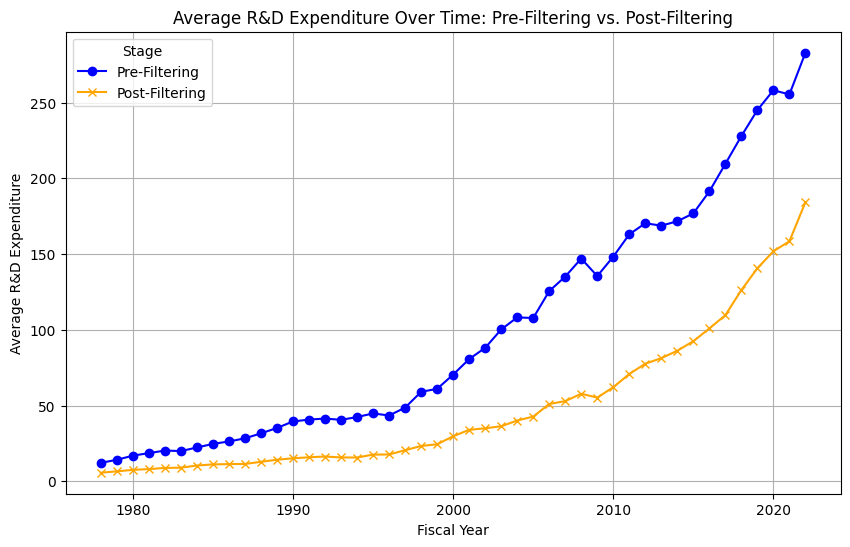

In [6]:
# Calculate Average R&D Expenditure Over Time (Pre-Filtering and Post-Filtering)
avg_rd_pre = compustat_pre.groupby('fyear')['xrd'].mean()
avg_rd_post = compustat.groupby('fyear')['xrd'].mean()

# Combine Data into a Single DataFrame
comparison_rd = pd.DataFrame({
    'Fiscal Year': avg_rd_pre.index,
    'Pre-Filtering': avg_rd_pre.values,
    'Post-Filtering': avg_rd_post.reindex(avg_rd_pre.index, fill_value=0).values
})

# Plot the Data
plt.figure(figsize=(10, 6))
plt.plot(comparison_rd['Fiscal Year'], comparison_rd['Pre-Filtering'], label='Pre-Filtering', marker='o', color='blue')
plt.plot(comparison_rd['Fiscal Year'], comparison_rd['Post-Filtering'], label='Post-Filtering', marker='x', color='orange')
plt.title('Average R&D Expenditure Over Time: Pre-Filtering vs. Post-Filtering')
plt.xlabel('Fiscal Year')
plt.ylabel('Average R&D Expenditure')
plt.legend(title='Stage')
plt.grid(True)
plt.show()



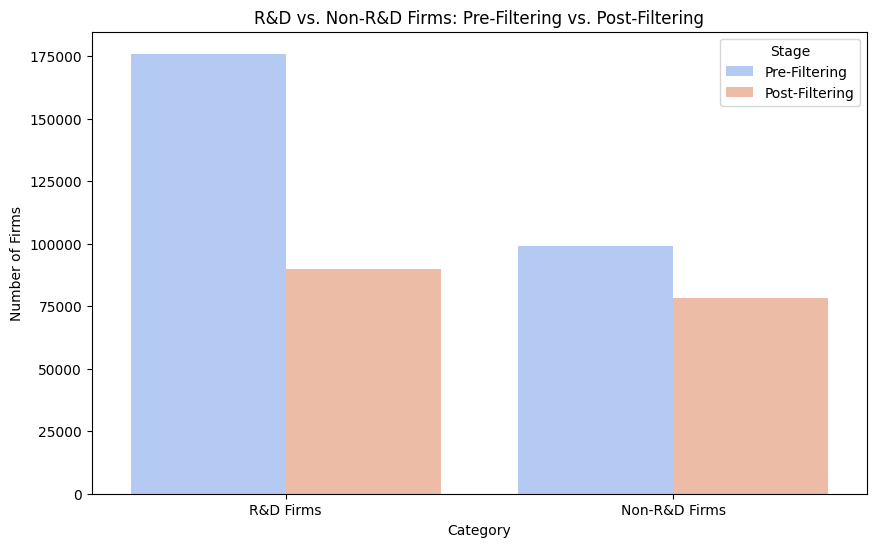

In [7]:
# Plot: R&D Firms vs Non-R&D Firms Comparison

compustat_pre['rd_category'] = compustat_pre['xrd'].apply(lambda x: 'R&D Firms' if x > 0 else 'Non-R&D Firms')
rd_counts_pre = compustat_pre['rd_category'].value_counts()

compustat['rd_category'] = compustat['xrd'].apply(lambda x: 'R&D Firms' if x > 0 else 'Non-R&D Firms')
rd_counts = compustat['rd_category'].value_counts()


comparison_data = pd.DataFrame({
    'Category': ['R&D Firms', 'Non-R&D Firms'],
    'Pre-Filtering': rd_counts_pre.values,
    'Post-Filtering': rd_counts.values
})

# Melt the DataFrame for Seaborn
comparison_melted = comparison_data.melt(id_vars='Category', 
                                         var_name='Stage', 
                                         value_name='Count')

# Plot the Data
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_melted, x='Category', y='Count', hue='Stage', palette='coolwarm')
plt.title('R&D vs. Non-R&D Firms: Pre-Filtering vs. Post-Filtering')
plt.xlabel('Category')
plt.ylabel('Number of Firms')
plt.legend(title='Stage')
plt.show()

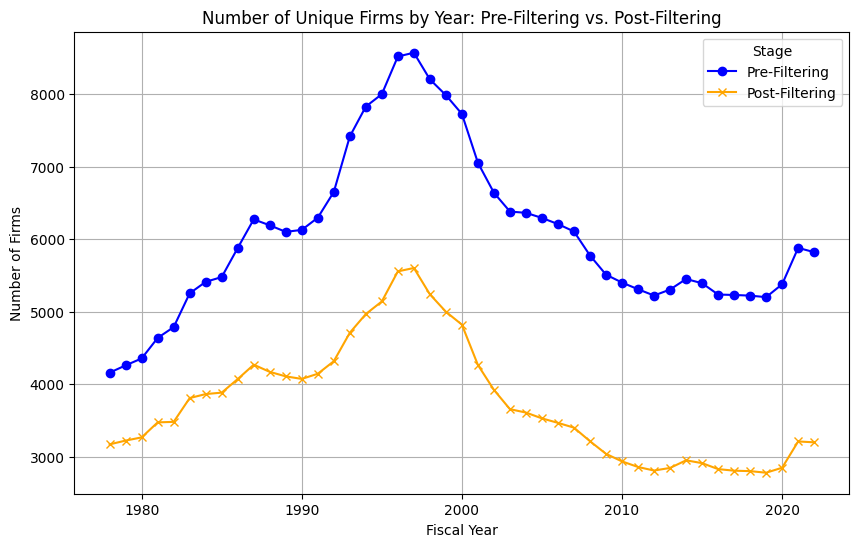

In [8]:
# Calculate Number of Unique Firms by Year (Pre-Cleaning and Post-Cleaning)
unique_firms_pre = compustat_pre.groupby('fyear')['GVKEY'].nunique()
unique_firms_post = compustat.groupby('fyear')['GVKEY'].nunique()

comparison_firms = pd.DataFrame({
    'Fiscal Year': unique_firms_pre.index,
    'Pre-Filtering': unique_firms_pre.values,
    'Post-Filtering': unique_firms_post.reindex(unique_firms_pre.index, fill_value=0).values
})

# Plot the Data
plt.figure(figsize=(10, 6))
plt.plot(comparison_firms['Fiscal Year'], comparison_firms['Pre-Filtering'], label='Pre-Filtering', marker='o', color='blue')
plt.plot(comparison_firms['Fiscal Year'], comparison_firms['Post-Filtering'], label='Post-Filtering', marker='x', color='orange')
plt.title('Number of Unique Firms by Year: Pre-Filtering vs. Post-Filtering')
plt.xlabel('Fiscal Year')
plt.ylabel('Number of Firms')
plt.legend(title='Stage')
plt.grid(True)
plt.show()

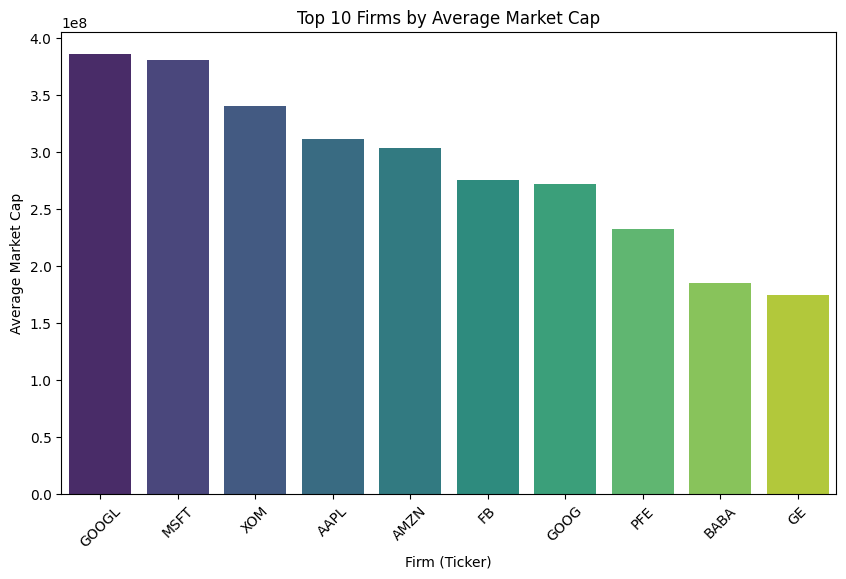

In [9]:
# Top Firms by Market Cap

top_firms = crsp.groupby('Ticker')['MthCap'].mean().nlargest(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_firms.index, y=top_firms.values, palette="viridis")
plt.title('Top 10 Firms by Average Market Cap')
plt.xlabel('Firm (Ticker)')
plt.ylabel('Average Market Cap')
plt.xticks(rotation=45)
plt.show()

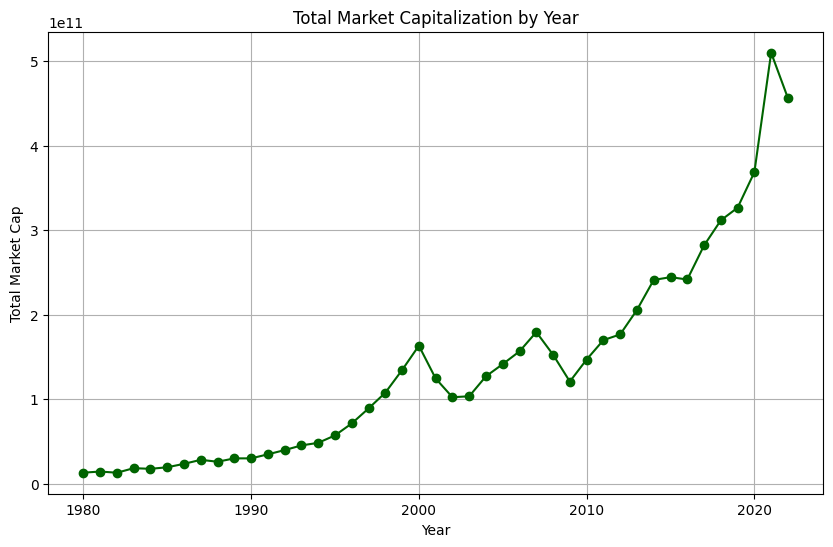

In [10]:
# Total market cap by year
total_market_cap = crsp.groupby('available_year')['MthCap'].sum()

plt.figure(figsize=(10, 6))
total_market_cap.plot(kind='line', marker='o', color='darkgreen')
plt.title('Total Market Capitalization by Year')
plt.xlabel('Year')
plt.ylabel('Total Market Cap')
plt.grid(True)
plt.show()

## Merging

In [11]:
# ==========================
# Step 3: Merging
# ==========================
merged_data = compustat[['GVKEY', 'LPERMNO', 'LINKDT', 'LINKENDDT', 'available_date', 'available_year', 'xrd']]
merged_data = merged_data.rename(columns = {'LPERMNO':'PERMNO'})
final_data = crsp.merge(
    merged_data, on=['PERMNO','available_year'], how='inner'
)

# Ensure date range is linked correctly
final_data = final_data[
    (final_data['MthCalDt'] >= final_data['LINKDT']) &
    (final_data['MthCalDt'] <= final_data['LINKENDDT'])
]

# Sort values to merge factors 
final_data = final_data.sort_values(by=['MthCalDt'], ascending=True)
final_data = final_data.reset_index(drop=True)

# Extract year and month from the date columns
factors['year'] = factors['date'].dt.year
factors['month'] = factors['date'].dt.month
final_data['year'] = final_data['MthCalDt'].dt.year
final_data['month'] = final_data['MthCalDt'].dt.month

# Merge factors data into final_data based on year and month
final_data = pd.merge(
    final_data,
    factors[['year', 'month', 'RMRF', 'RF']],  
    on=['year', 'month'],                      # Merge on year and month
    how='left'                                 # Left join to retain all final_data rows
)

final_data = final_data[(final_data['MthCalDt'] >= '1980-01-01') & (final_data['MthCalDt'] <= '2022-12-31')]

print("Final merged dataset. Number of rows:", len(final_data))
print("Sample of merged data:\n", final_data.head())

Final merged dataset. Number of rows: 1678779
Sample of merged data:
    PERMNO  HdrCUSIP     CUSIP PrimaryExch  \
0   17822  87114010  87114010           N   
1   48128  50105310  50105310           Q   
2   48100  47073610  47073610           N   
3   48098  90479030  90479010           A   
4   26112  24736110  24736110           N   

                            SecurityNm Ticker  PERMCO  SICCD   MthCalDt  \
0          SYBRON CORP; COM NONE; CONS    SYB   22808   3841 1980-01-31   
1  KROY INDUSTRIES INC; COM NONE; CONS   KROY    2579      0 1980-01-31   
2        JAMESWAY CORP; COM NONE; CONS    JMY   21013   5311 1980-01-31   
3     UNIMAX GROUP INC; COM NONE; CONS    UMX   24980   3662 1980-01-31   
4  DELTA AIR LINES INC; COM NONE; CONS    DAL   20569   4511 1980-01-31   

   MthPrc  ...  available_year  GVKEY     LINKDT  LINKENDDT  available_date  \
0   17.75  ...            1980  10227 1963-01-31 1986-02-28      1979-03-31   
1   33.50  ...            1980   6503 1972-12-14 1

In [19]:
len(final_data)

1678779

## Portfolio Construction

In [12]:
# ==========================
# Step 4: Portfolio Construction
# ==========================

# Create R&D Groups: 0 for no expense and 1 for present expense
final_data['group'] = final_data['xrd'].apply(lambda x: 1 if x > 0 else 0)
group_counts = final_data['group'].value_counts()
print("Group distribution:\n", group_counts)

Group distribution:
 group
0    890830
1    787949
Name: count, dtype: int64


In [13]:
# Equally Weighted Returns
ew_returns = final_data.groupby(['MthCalDt', 'group'])['MthRet'].mean().reset_index()
ew_returns = ew_returns.rename(columns={'MthRet': 'ew_return'})

# Value-Weighted Returns
final_data['market_cap_shifted'] = final_data.groupby('PERMNO')['MthCap'].shift(1)
final_data['weights'] = final_data['market_cap_shifted'] / final_data.groupby(['MthCalDt', 'group'])['market_cap_shifted'].transform('sum')
final_data['weighted_ret'] = final_data['weights'] * final_data['MthRet']
vw_returns = final_data.groupby(['MthCalDt', 'group'])['weighted_ret'].sum().reset_index()
vw_returns = vw_returns.rename(columns={'weighted_ret': 'vw_return'})

portfolios = pd.merge(ew_returns, vw_returns, on=['MthCalDt', 'group'])

portfolios = portfolios.merge(final_data[['MthCalDt', 'RMRF','RF']].drop_duplicates(), on='MthCalDt', how='left')

print("Number of rows in portfolio dataset:", len(portfolios))
portfolios['ew_excess_return'] = portfolios['ew_return'] - portfolios['RF']
portfolios['vw_excess_return'] = portfolios['vw_return'] - portfolios['RF']

Number of rows in portfolio dataset: 1032


In [24]:
final_data[final_data['PERMNO']==10001]

,PERMNO,HdrCUSIP,CUSIP,PrimaryExch,SecurityNm,Ticker,PERMCO,SICCD,MthCalDt,MthPrc,...,available_date,xrd,year,month,RMRF,RF,group,market_cap_shifted,weights,weighted_ret
260321,10001,36720410,39040610,Q,GREAT FALLS GAS CO; COM NONE; CONS,GFGC,7953,4920,1987-01-30,6.7500,...,1986-09-28,0.0,1987,1,0.1247,0.0042,0,NaN,NaN,NaN
264016,10001,36720410,39040610,Q,GREAT FALLS GAS CO; COM NONE; CONS,GFGC,7953,4920,1987-02-27,6.2500,...,1986-09-28,0.0,1987,2,0.0439,0.0043,0,6689.25,0.000008,-6.173150e-07
266886,10001,36720410,39040610,Q,GREAT FALLS GAS CO; COM NONE; CONS,GFGC,7953,4920,1987-03-31,6.3750,...,1986-09-28,0.0,1987,3,0.0164,0.0047,0,6193.75,0.000007,2.765001e-07
270893,10001,36720410,39040610,Q,GREAT FALLS GAS CO; COM NONE; CONS,GFGC,7953,4920,1987-04-30,6.1250,...,1986-09-28,0.0,1987,4,-0.0211,0.0044,0,6317.63,0.000007,-2.922136e-07
273535,10001,36720410,39040610,Q,GREAT FALLS GAS CO; COM NONE; CONS,GFGC,7953,4920,1987-05-29,5.6875,...,1986-09-28,0.0,1987,5,0.0011,0.0038,0,6069.88,0.000007,-5.321741e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1510760,10001,36720410,36720410,A,GAS NATURAL INC; COM NONE; CONS,EGAS,7953,4925,2017-04-28,12.5000,...,2016-03-30,0.0,2017,4,0.0109,0.0005,0,133604.00,0.000019,-2.931197e-07
1513898,10001,36720410,36720410,A,GAS NATURAL INC; COM NONE; CONS,EGAS,7953,4925,2017-05-31,12.7000,...,2016-03-30,0.0,2017,5,0.0106,0.0006,0,131500.00,0.000018,2.916454e-07
1515175,10001,36720410,36720410,A,GAS NATURAL INC; COM NONE; CONS,EGAS,7953,4925,2017-06-30,12.9250,...,2016-03-30,0.0,2017,6,0.0078,0.0006,0,133604.00,0.000019,4.402219e-07
1518112,10001,36720410,36720410,A,GAS NATURAL INC; COM NONE; CONS,EGAS,7953,4925,2017-07-31,12.9500,...,2016-03-30,0.0,2017,7,0.0187,0.0007,0,135971.00,0.000019,3.697244e-08


In [14]:
# ==========================
# Step 4: Performing Regression
# ==========================

def run_regression(y, x):
    x = sm.add_constant(x)  # Add intercept
    model = sm.OLS(y, x).fit()
    return model

# Run regressions for equal-weighted and value-weighted portfolios for both groups
results = []
for group in [0, 1]: 
    for col in ['ew_excess_return', 'vw_excess_return']:
        subset = portfolios[portfolios['group'] == group]
        y = subset[col]
        x = subset['RMRF']
        model = run_regression(y, x)
        
        # Format p-values for cleaner display
        alpha_p = model.pvalues['const']
        beta_p = model.pvalues['RMRF']
        alpha_p_display = f"p < 0.001" if alpha_p < 0.001 else f"{alpha_p:.3f}"
        beta_p_display = f"p < 0.001" if beta_p < 0.001 else f"{beta_p:.3f}"
        
        # Append data to results
        results.append({
            'Portfolio': f'{"Value-Weighted" if "vw" in col else "Equal-Weighted"}, {"R&D" if group == 1 else "No R&D"}',
            'Alpha': model.params['const'],
            'Alpha SE': model.bse['const'],  # Standard Error for Alpha
            'Alpha P-Value': alpha_p_display,
            'Beta': model.params['RMRF'],
            'Beta SE': model.bse['RMRF'],   # Standard Error for Beta
            'Beta P-Value': beta_p_display,
            'R-squared': model.rsquared,
        })

# Convert results to DataFrame
regression_results = pd.DataFrame(results)
regression_results

,Portfolio,Alpha,Alpha SE,Alpha P-Value,Beta,Beta SE,Beta P-Value,R-squared
0,"Equal-Weighted, No R&D",0.000987,0.001379,0.474,1.062982,0.029986,p < 0.001,0.709713
1,"Value-Weighted, No R&D",0.000228,0.000598,0.703,0.907673,0.012997,p < 0.001,0.904662
2,"Equal-Weighted, R&D",0.001399,0.001771,0.430,1.260622,0.038522,p < 0.001,0.675691
3,"Value-Weighted, R&D",0.000244,0.000694,0.726,1.082118,0.015101,p < 0.001,0.909005


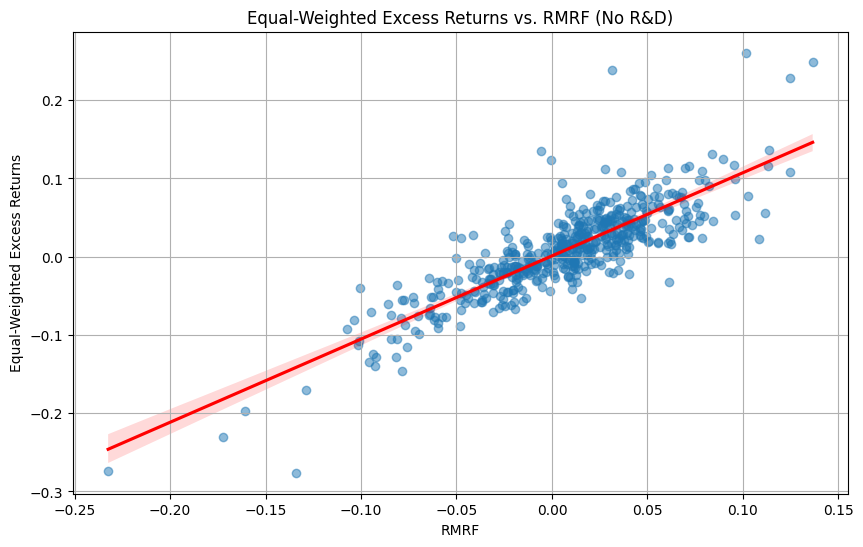

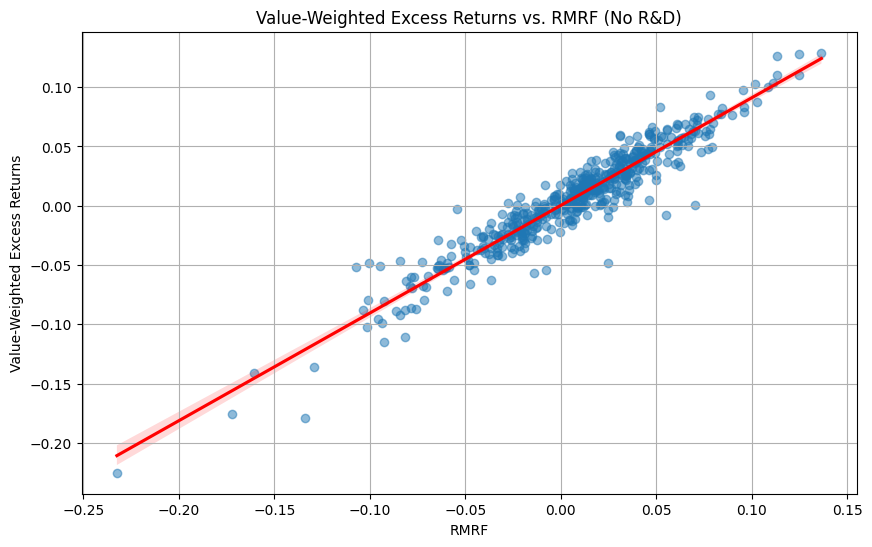

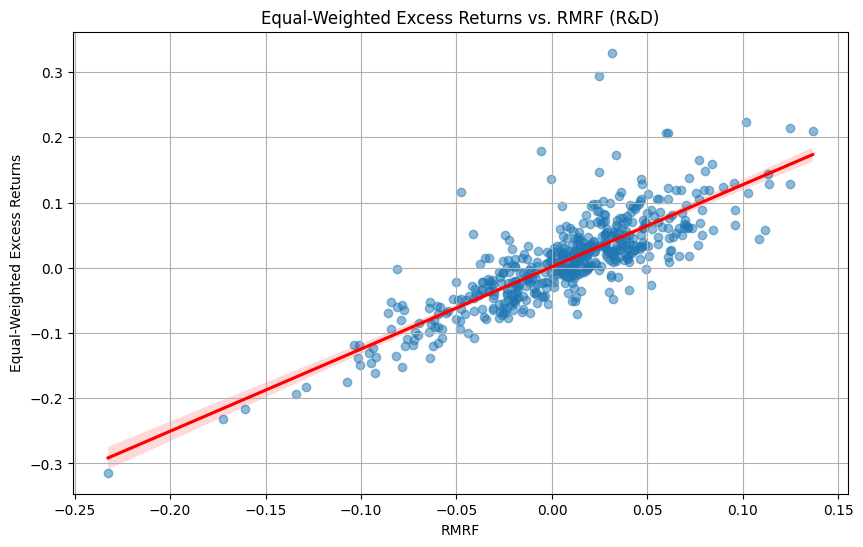

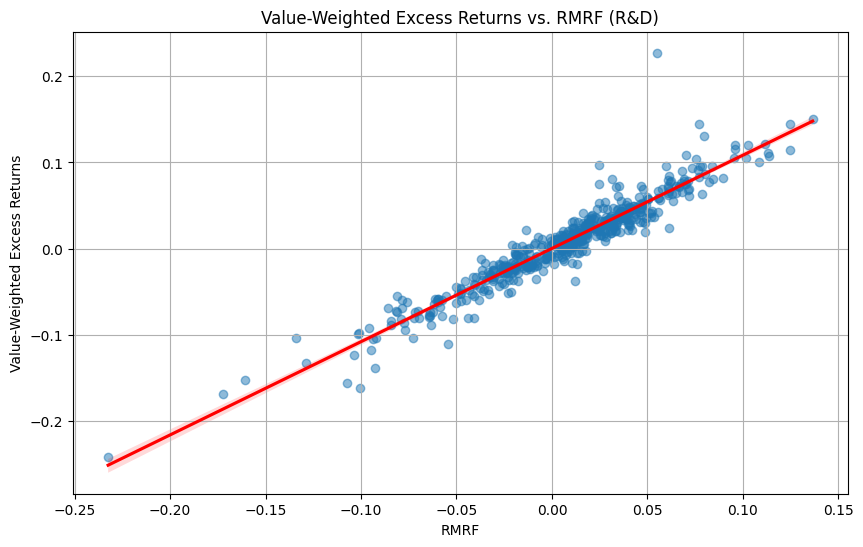

In [15]:
for group in [0, 1]:
    for col in ['ew_excess_return', 'vw_excess_return']:
        plt.figure(figsize=(10, 6))
        subset = portfolios[portfolios['group'] == group]
        sns.regplot(
            x='RMRF', y=col, data=subset, 
            scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'}
        )
        plt.title(f"{'Equal-Weighted' if 'ew' in col else 'Value-Weighted'} Excess Returns vs. RMRF ({'R&D' if group == 1 else 'No R&D'})")
        plt.xlabel('RMRF')
        plt.ylabel(f"{'Equal-Weighted' if 'ew' in col else 'Value-Weighted'} Excess Returns")
        plt.grid(True)
        plt.show()

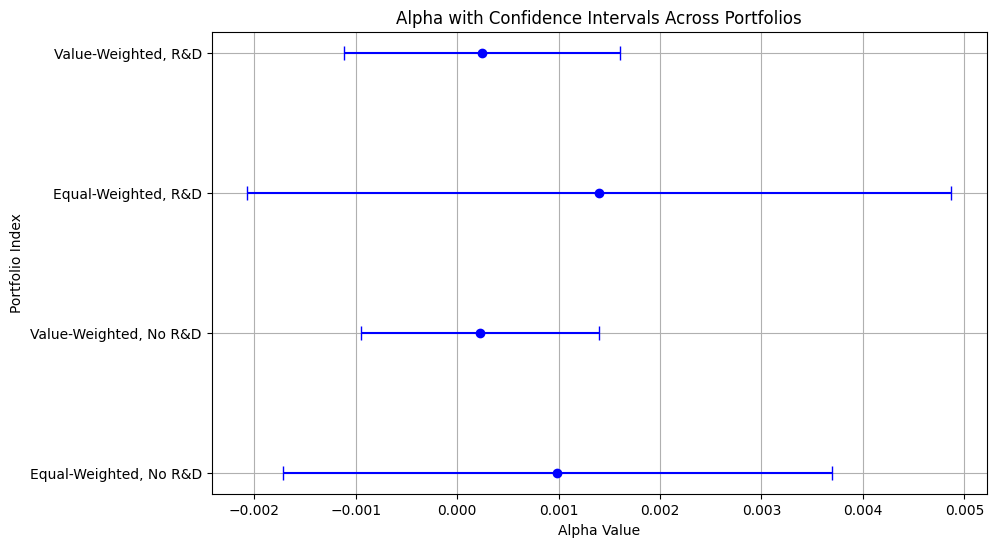

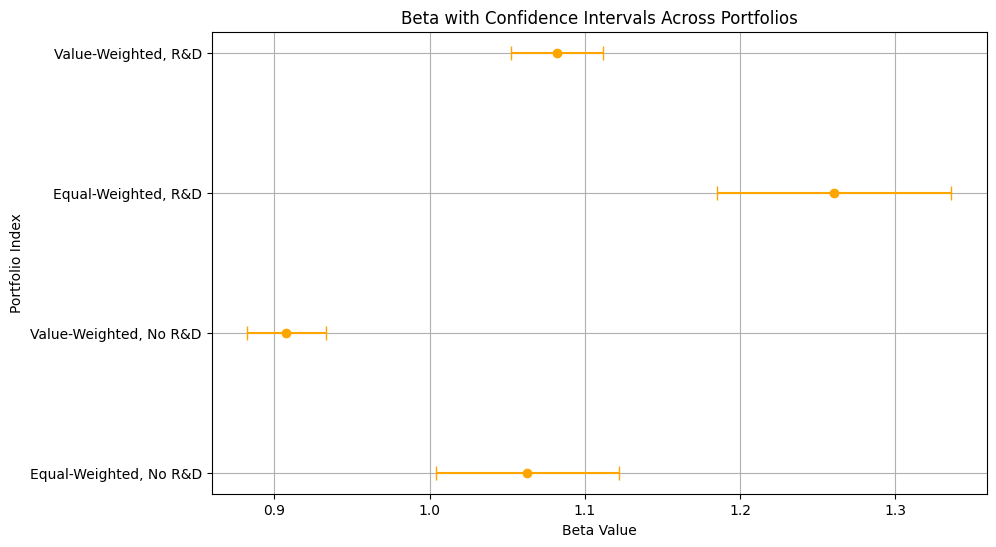

In [16]:
# Calculate Confidence Intervals
regression_results['Alpha Upper'] = regression_results['Alpha'] + 1.96 * regression_results['Alpha SE']
regression_results['Alpha Lower'] = regression_results['Alpha'] - 1.96 * regression_results['Alpha SE']
regression_results['Beta Upper'] = regression_results['Beta'] + 1.96 * regression_results['Beta SE']
regression_results['Beta Lower'] = regression_results['Beta'] - 1.96 * regression_results['Beta SE']

# Error Bar Plot for Alpha
plt.figure(figsize=(10, 6))
for idx, row in regression_results.iterrows():
    plt.errorbar(
        x=row['Alpha'], y=idx, 
        xerr=[[row['Alpha'] - row['Alpha Lower']], [row['Alpha Upper'] - row['Alpha']]], 
        fmt='o', label=row['Portfolio'] if idx == 0 else "", capsize=5, color='blue'
    )
plt.title('Alpha with Confidence Intervals Across Portfolios')
plt.xlabel('Alpha Value')
plt.ylabel('Portfolio Index')
plt.yticks(ticks=range(len(regression_results)), labels=regression_results['Portfolio'])
plt.grid(True)
plt.show()

# Error Bar Plot for Beta
plt.figure(figsize=(10, 6))
for idx, row in regression_results.iterrows():
    plt.errorbar(
        x=row['Beta'], y=idx, 
        xerr=[[row['Beta'] - row['Beta Lower']], [row['Beta Upper'] - row['Beta']]], 
        fmt='o', label=row['Portfolio'] if idx == 0 else "", capsize=5, color='orange'
    )
plt.title('Beta with Confidence Intervals Across Portfolios')
plt.xlabel('Beta Value')
plt.ylabel('Portfolio Index')
plt.yticks(ticks=range(len(regression_results)), labels=regression_results['Portfolio'])
plt.grid(True)
plt.show()


    group  ew_return  vw_return  ew_excess_return  vw_excess_return
0  No R&D   0.011481   0.009663          0.008226          0.006409
1     R&D   0.013238   0.010868          0.009984          0.007613


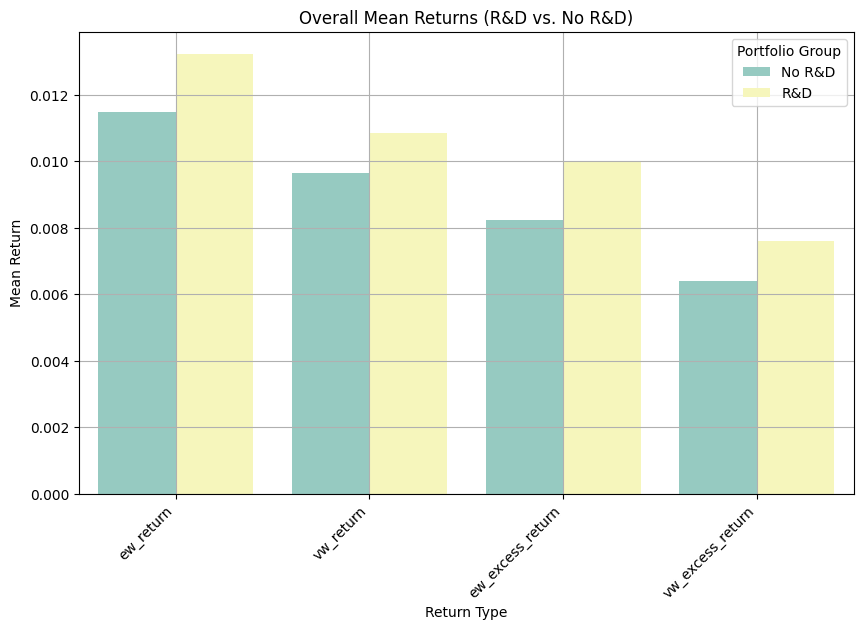

In [17]:
# Calculate Overall Mean Returns for R&D vs. No R&D
overall_means = portfolios.groupby('group').agg({
    'ew_return': 'mean',
    'vw_return': 'mean',
    'ew_excess_return': 'mean',
    'vw_excess_return': 'mean'
}).reset_index()

overall_means['group'] = overall_means['group'].map({0: 'No R&D', 1: 'R&D'})

print(overall_means)
overall_means_melted = overall_means.melt(id_vars='group', var_name='Return Type', value_name='Mean Return')

plt.figure(figsize=(10, 6))
sns.barplot(data=overall_means_melted, x='Return Type', y='Mean Return', hue='group', palette='Set3')
plt.title('Overall Mean Returns (R&D vs. No R&D)')
plt.xlabel('Return Type')
plt.ylabel('Mean Return')
plt.legend(title='Portfolio Group')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()